In [1]:
import scipy as sp
import scipy.sparse as spsp
import numpy as np
from math import cos, tan, exp,log, sin,
import scipy.sparse.linalg as spl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D
from sklearn.preprocessing import  MinMaxScaler
import seaborn as sns

# DIFFERENCES FINIES 2D

In [2]:
class Solver2D :
    def __init__(self, f,u,n,m,):
        self.f = f
        self.n= n
        self.m = m
        self.h = 1/self.n
        self.k = 1/self.m
        self.u = u
        
    # calcul des différents points du maillage
    def fmaillage(self):
        fmail =[]
        a = self.h
        b = self.k 
        for j in range(1, self.m) :
            for i in range(1, self.n): 
                fpoint = self.f(i*a,j*b) 
               
                if(((i+1==self.n)and(j+1==self.m))|((i-1==0)and(j-1==0))):
                    if((i+1==self.n)and(j+1==self.m)):
                        fmail.append(fpoint+self.u(1,j*b)/a**2+
                                     self.u(i*a,1)/b**2)
                    if((i-1==0)and(j-1==0)):
                        fmail.append(fpoint+self.u(0,j*b)/a**2+
                                     self.u(i*a,0)/b**2)   


                else :
                    if((i+1==self.n)and(j-1==0)):
                        fmail.append(fpoint+ self.u(1,j*b)/a**2+ self.u(i*a,0)/b**2)

                    elif((i+1==self.n)and(1<j<self.m-1)):
                        fmail.append(self.f(i*self.h,j*self.k)+self.u(1,j*self.k)/self.h**2)
                    elif((i==1)and(j+1==self.m)):
                        fmail.append(fpoint+ self.u(0,j*b)/a**2+self.u(i*a,1)/b**2)
                    elif((i==1)and(1<j<self.m-1)):
                        fmail.append(self.f(i*a,j*b)+self.u(0,j*b)/a**2)
                    elif((j+1==self.m)and(1<i<self.n-1)):
                        fmail.append(self.f(i*self.h,j*self.k)+self.u(i*self.h,1)/self.k**2) 
                    elif((j-1==0)and(1<i<self.n-1)):
                        fmail.append(self.f(i*a,j*b)+self.u(i*a,0)/b**2)  
                    else:
                        fmail.append(self.f(i*a,j*b))
                
        return np.array(fmail)
    
   #matrice du système au format ccs     
    def stockMatrix(self):
        taille = (self.m-1)*(self.n-1)
        val1 = (2*np.ones(taille))/self.h**2 + (2*np.ones(taille))/self.k**2
        val2= []
        for j in range(0, self.m-1):
            for i in range(0, self.n-1):
                if(i<self.n-2):
                    val2.append(-1/self.h**2)
                else:
                    val2.append(0)
        val3 = -1*np.ones(taille)/self.k**2
        val4 = val2[::-1]
        data = np.array([val3,val2, val1, val4, val3])
        diags1 = np.array([-self.n+1,-1,0,1,self.n-1])
        mat = spsp.spdiags(data, diags1, taille , taille)
        return mat.tocsc()
    
    #Résolution du système d'équations
    def solveSystem (self, csc, b):
        lu = spl.splu(csc)
        sol = lu.solve(b)
        return sol
    
    #Calcul de la solution exacte aux points données du maillage
    def soltEx(self):
        soltEx =[]
        for j in range(1,self.m):
            for i in range(1, self.n):
                soltEx.append(self.u(self.h*i, self.k*j))
        return soltEx
    
    #Tracé de la surface d'erreur 3D
    def tracer_graphe_erreur(self, error) :
        cm = plt.cm.get_cmap('RdYlBu')
        x, y = [],[]
        a = (self.n-1)*(self.m-1)
        b2 = range(1,a+1) # b2 représente le tableau des couleurs associées aux points à représenter
        for j in range(1,self.m): #la fonction range(1,n-1) renvoie un tableau d'entier de 1 à n-2
            for i in range(1,self.n):
                x.append(i*self.h)
                y.append(j*self.k)
        fig = plt.figure() 
        ax = Axes3D(fig)
        line = ax.scatter(x,y,error,c=b2,s=200,marker='.',edgecolor='none',depthshade=0, cmap = cm)
        plt.colorbar(line)
        ax.set_xlabel('x axis')
        ax.set_ylabel('y axis')
        ax.set_zlabel('z axis')
    
    def errorGrid(self, error):
        scaler = MinMaxScaler()
        error_scale = scaler.fit_transform(error.reshape(-1,1))
        error_scale = np.array(error_scale)
        error_scale = error_scale.astype(float)
        tab = []
        index = 0
        for j in range(1,self.m):
            l = []
            for i in range(1, self.n):
                l.append(float(error_scale[index+i-1]))
            index += self.n-1
            tab.append(l)
        plt.figure(figsize = (12,8))
        tab = np.array(tab)
        sns.heatmap(tab, vmin = 0, vmax = 1, cmap = "Blues")
    

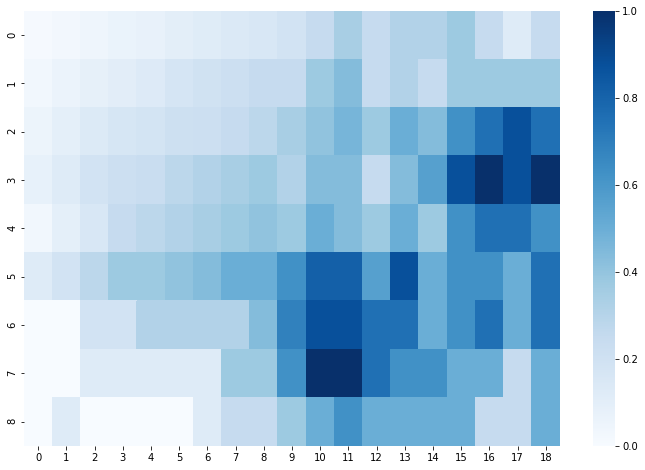

In [3]:
solver = Solver2D(lambda x,y : -6*x-6*y,lambda x,y:x**3+y**3,20,10)
csc=solver.stockMatrix()
maill = solver.fmaillage()
appr=solver.solveSystem(csc,maill)
exact=solver.soltEx()
err=abs(exact-appr)
scale = solver.errorGrid(err)
scale

# Estimation de la vitesse de convergence du programme pour les tests

In [4]:
from sklearn.linear_model import LinearRegression
def vitesseConvergence(f, u, n1, n2):
    taille = 20
    tabh = np.array([k for k in range(n1,n2 + taille, taille)])
    tabk = np.array([k for k in range(n1,n2 + taille, taille)])
    error = []
    X= []
    for elem in range(0, len(tabh)):
        solver2d = Solver2D(f,u,tabh[elem], tabk[elem] )
        matrix = solver2d.stockMatrix()
        soltex= solver2d.soltEx()
        maill = solver2d.fmaillage()
        soltAppr = solver2d.solveSystem(matrix, maill)
        err = abs(soltAppr-soltex)
        error.append(log(max(err)))
    X= np.array([log(max(1/tabh[i],1/tabk[i])) for i in range(0, len(tabh))])
    reg = LinearRegression()
    reg.fit(X.reshape(-1,1), np.array(error))
    plt.figure()
    plt.plot(X,error)
    return reg.coef_

# Tests du programme

In [95]:
"'cette première fonction de test c'est celle des Polynomes en dim2 qui renvoit true ou False si"
"l'erreur est plus petite que la tolerance"
def testFunctionSimple(f, u, n,m, tol):
    solver = Solver2D(f,u,n,m)
    matrice2d = solver.stockMatrix()
    fmail = solver.fmaillage()
    exact = solver.soltEx()
    appro = solver.solveSystem(matrice2d, fmail)
    return(max(abs((exact-appro))/exact)<tol)

def testFunctionNulle(f, u, n,m, tol):
    solver = Solver2D(f,u,n,m)
    matrice2d = solver.stockMatrix()
    fmail = solver.fmaillage()
    exact = solver.soltEx()
    appro = solver.solveSystem(matrice2d, fmail)
    return(max(abs(exact-appro))<tol)
    
#Cette deuxième fonction c'est pour d'autres types de fonctions dont on connait la solution le test est réussi si p>=2
def testFunctionComplex(f, u, n, m, tol= 1E-3):
    vitConv = vitesseConvergence(f,u,n,m)
    return vitConv >= 2 - 1E-3


### Cas de test fonction nulle

In [41]:
vit1 = testFunctionNulle(lambda x,y : 0,lambda x,y:0,100,200,1E-8)
vit1

True

### Cas de test fonction Polynome de degre < 2

In [104]:

DE   = [{'f': lambda x,y : -24, 'u': lambda x,y: 12*x**2 , 'n': 100, 'm':200 , 'tol': 1E-8 }, 
        {'f': lambda x,y : 12*y, 'u': lambda x,y: -6*(x**2)*y , 'n': 100, 'm':200 , 'tol': 1E-8 },
        {'f': lambda x,y: 0, 'u': lambda x,y: 3*x, 'n': 100 , 'm':200 , 'tol': 1E-8},
        {'f': lambda x,y : -24, 'u': lambda x,y: 12*y**2 , 'n': 100, 'm':200 , 'tol': 1E-8 }, 
        {'f': lambda x,y : 12*x, 'u': lambda x,y: -6*(y**2)*x , 'n': 100, 'm':200 , 'tol': 1E-8},
        {'f': lambda x,y: 0, 'u': lambda x,y: 3*y, 'n': 100 , 'm':200 , 'tol': 1E-8 },
        {'f': lambda x,y : -24, 'u': lambda x,y: 12*x**2 , 'n': 200, 'm':100 , 'tol': 1E-8 }, 
        {'f': lambda x,y : 12*y, 'u': lambda x,y: -6*(x**2)*y , 'n': 200, 'm':100 , 'tol': 1E-8 },
        {'f': lambda x,y: 0, 'u': lambda x,y: 3*x, 'n': 200 , 'm':100 , 'tol': 1E-8},
        {'f': lambda x,y : -24, 'u': lambda x,y: 12*y**2 , 'n': 200, 'm':100 , 'tol': 1E-8 }, 
        {'f': lambda x,y : 12*x, 'u': lambda x,y: -6*(y**2)*x , 'n': 200, 'm':100 , 'tol': 1E-8},
        {'f': lambda x,y: 0, 'u': lambda x,y: 3*y, 'n': 200 , 'm':100 , 'tol': 1E-8 },

      ]

boolResult = []
print(len(DE))
for i in range(0, len(DE)):
    boolResult.append(testFunctionSimple(DE[i]['f'], DE[i]['u'], DE[i]['n'],DE[i]['m'],DE[i]['tol'] )) 
print(len(boolResult))
print(boolResult)


12
12
[True, True, True, True, True, True, True, True, True, True, True, True]


### Cas de test fonction Complexes

16
[True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, False]


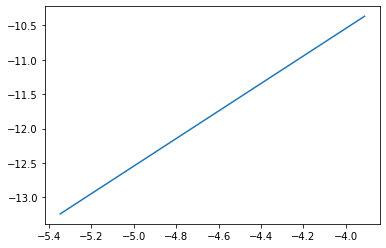

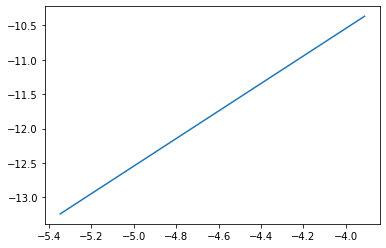

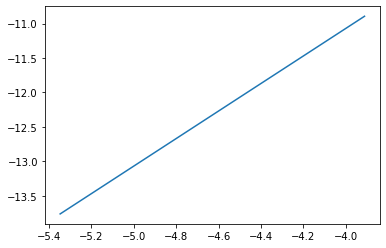

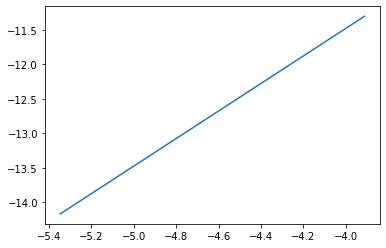

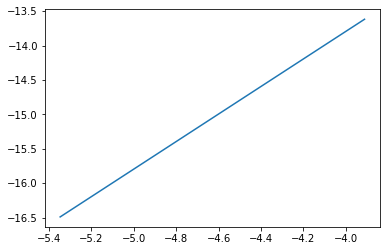

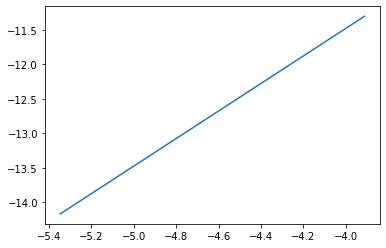

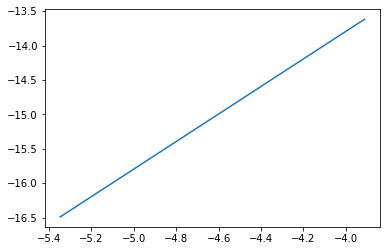

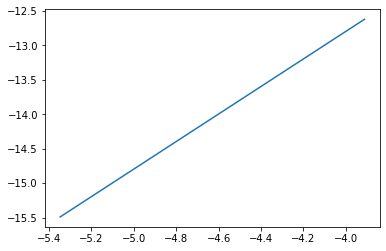

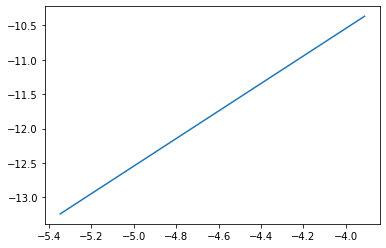

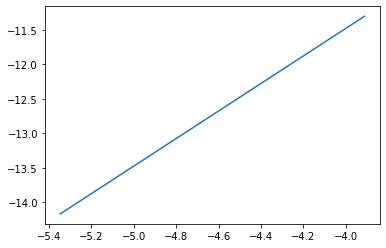

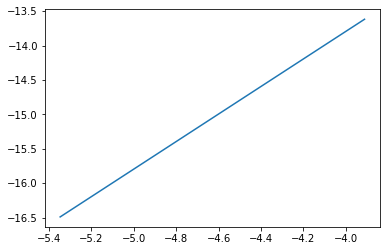

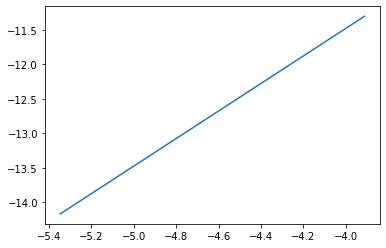

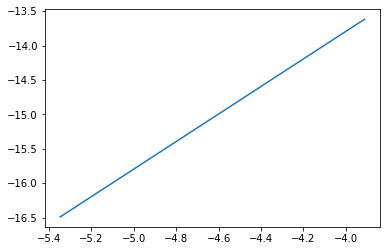

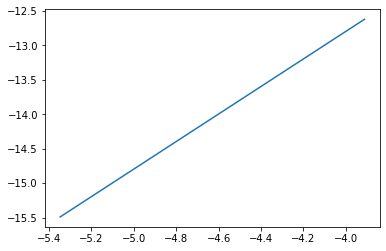

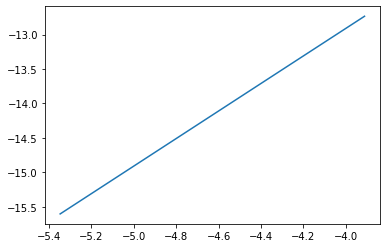

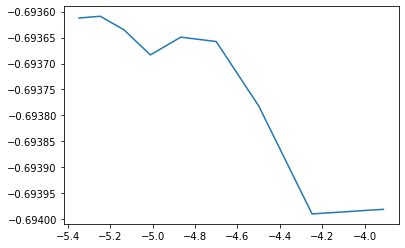

In [103]:
DE2 = [{'f': lambda x,y : -12*(x**2)*y, 'u': lambda x,y : (x**4)*y , 'n': 100, 'm':200, 'tol': 1E-8},
        {'f': lambda x,y : -12*(y**2)*x, 'u': lambda x,y : (y**4)*x , 'n': 100, 'm':200, 'tol': 1E-8},
        {'f': lambda x,y : -12*(x**2)*(y**4)-12*(x**4)*(y**2), 'u': lambda x,y : (x**4)*(y**4) , 'n': 100, 'm':200, 'tol': 1E-8},
        {'f': lambda x,y: -2/((x+1)**3), 'u': lambda x,y: 1/(x+1) , 'n': 100, 'm':200 , 'tol': 1E-8},
        {'f': lambda x,y: sin(x), 'u': lambda x,y: sin(x) , 'n': 100, 'm':200 , 'tol': 1E-8},
        {'f': lambda x,y: -2/((y+1)**3), 'u': lambda x,y: 1/(y+1) , 'n': 100, 'm':200 , 'tol': 1E-8 },
        {'f': lambda x,y: sin(y), 'u': lambda x,y: sin(y) , 'n': 100, 'm':200 , 'tol': 1E-8 },
        {'f': lambda x,y: sin(x)+cos(y), 'u': lambda x,y: sin(x)+cos(y) , 'n': 100, 'm':200,  'tol': 1E-8},
        {'f': lambda x,y : -12*(x**2)*y, 'u': lambda x,y : (x**4)*y , 'n': 200, 'm':100, 'tol': 1E-8},
        {'f': lambda x,y: -2/((x+1)**3), 'u': lambda x,y: 1/(x+1) , 'n': 200, 'm':100 , 'tol': 1E-8},
        {'f': lambda x,y: sin(x), 'u': lambda x,y: sin(x) , 'n': 200, 'm':100 , 'tol': 1E-8},
        {'f': lambda x,y: -2/((y+1)**3), 'u': lambda x,y: 1/(y+1) , 'n': 200, 'm':100 , 'tol': 1E-8 },
        {'f': lambda x,y: sin(y), 'u': lambda x,y: sin(y) , 'n': 200, 'm':100 , 'tol': 1E-8 },
        {'f': lambda x,y: sin(x)+cos(y), 'u': lambda x,y: sin(x)+cos(y) , 'n': 200, 'm':100,  'tol': 1E-8},
        {'f': lambda x,y: 1/(x+1.1)**2, 'u': lambda x,y: log(x+1.1) , 'n': 200, 'm':100 , 'tol': 1E-8 },
        {'f': lambda x,y: exp(x)+exp(y), 'u': lambda x,y: exp(x)+exp(y) , 'n': 100, 'm':100 , 'tol': 1E-8 },

      ]

vit = []
print(len(DE2))
for i in range(0, len(DE2)):
    vit.append(testFunctionComplex(DE2[i]['f'], DE2[i]['u'], 50,200 )[0]) 
print(vit)